In [1]:
import threading
import requests
import imutils
import cv2
import re
from os.path import join
from skimage.measure import compare_ssim
from matplotlib import pyplot as plt

In [2]:
DEBUG = True
TARGET_DIR= "/data/pictures"
RNN_URL = "http://192.168.1.209:5000/process"
REGEX = "Cat: ([a-zA-Z]+) with probability:([0-9.]+)"

In [177]:
# extract deltas and trigger RNN
def process(ref, img):
    global cre
    
    _cat = ""
    _proba = "0.0"

    if DEBUG : print("Processing - ref : {0}, img : {1}".format(ref, img))
    imageR = cv2.imread(join(TARGET_DIR,ref))
    imageD = cv2.imread(join(TARGET_DIR,img))
    
    grayR = cv2.cvtColor(imageR, cv2.COLOR_BGR2GRAY)
    grayD = cv2.cvtColor(imageD, cv2.COLOR_BGR2GRAY)
    
    (score, diff) = compare_ssim(grayR, grayD, full=True)
    diff = (diff * 255).astype("uint8")
    print("SSIM: {}".format(score))
    
    subimg = cv2.absdiff(imageD, imageR)
    subimg = cv2.threshold(cv2.cvtColor(subimg, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_OTSU)[1]
    subimg0 = subimg
        
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    subimg += thresh
        
    titles = ["SubImg0", "Thresh", "SubImg"]
    images = [subimg0, thresh, subimg]
    
    for i in range(3):
        plt.subplot(1,3,i+1),plt.imshow(images[i], 'gray')
        plt.title(titles[i])
        #plt.xticks([]), plt.yticks([])
    plt.show()

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        if (w > 200 and h > 200):
             if DEBUG : print("Found object : x = {0}, y = {1}, w = {2}, h = {3}".format(x, y, w, h))
             cv2.imwrite(join("extract" + str(h) + str(w) + ".jpg"), imageD[y:y+h, x:x+w])

             files = { 'image_file' : open("extract" + str(h) + str(w) + ".jpg", 'rb') }
             values = {}
             req = requests.put(RNN_URL,files=files,data=values)

             if DEBUG : print(req.text)
             
             result = cre.search(req.text)
             _cat = result.group(1)
             _proba = result.group(2)

             if DEBUG : print("Found : ", _cat," with ", _proba)
    return _cat, _proba

In [178]:
cre = re.compile(REGEX)

In [179]:
s = "E:/temp/180819/01-20190818025308-00.jpg"
t = "E:/temp/180819/01-20190818025239-00.jpg"

Processing - ref : E:/temp/180819/01-20190818025308-00.jpg, img : E:/temp/180819/01-20190818025239-00.jpg
SSIM: 0.8864653327818653


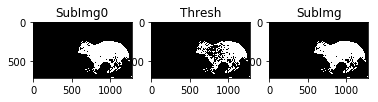

Found object : x = 585, y = 239, w = 667, h = 417
Cat: grokado with probability:0.95188755

Found :  grokado  with  0.95188755


In [180]:
(cat, proba) = process(s,t)